In [1]:
import matplotlib.pyplot as plt

import random
import numpy as np
import scipy.special as SS
import scipy.stats as SSA
from scipy import sparse

import pandas as pd
import copy
import math
import os
import sys
import time

In [3]:
pop = np.loadtxt('../data/pop_new.csv')
# My Rtx at time 0 is [2.5,5.5] and scaled with the population at the location and the decrease 1% per day. 

change with population size

In [28]:
T = 60  # number of days
decay_rate = 0.99  # 1% decay per day

# Scale Rt0 from [2, 5.5] linearly based on population
pop_min, pop_max = pop.min(), pop.max()
Rt0 = 2.5 + (pop - pop_min) / (pop_max - pop_min) * (4 - 2.5)  # shape (N,)

# Apply exponential decay over time
decay = decay_rate ** np.arange(T).reshape(-1, 1)  # shape (T, 1)
Rtx = decay * Rt0.reshape(1, -1)

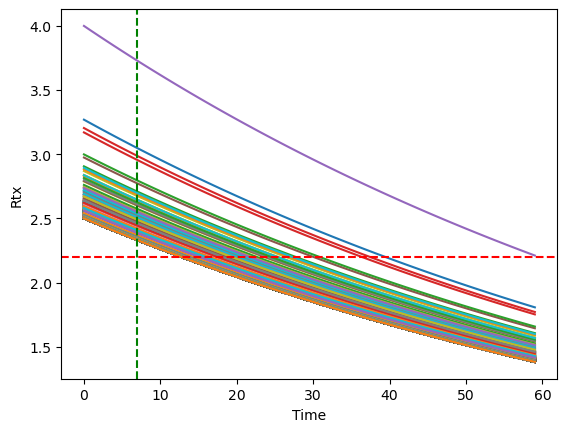

In [29]:
for i in range(3142):
    plt.plot(Rtx[:,i])
plt.xlabel('Time')
plt.ylabel('Rtx')
plt.axhline(2.2, color='red', linestyle='--', label='R=1')
plt.axvline(7.0, color='green', linestyle='--', label='R=0')

In [ ]:
# np.savetxt('Rtx_synthetic.csv', Rtx)

In [77]:
def create_Rtx(quan,min_val=2.5, max_val=4):
    T = 60  # number of days
    N = len(quan)  # number of locations
    quan_min, quan_max = quan.min(), quan.max()

    # Initial Rt0 scaled by quanulation
    Rt0 = min_val + (quan - quan_min) / (quan_max - quan_min) * (max_val - min_val)  # shape (N,)

    # Sigmoid decay parameters
    k = 0.2      # steepness
    t0 = T / 2   # midpoint (day 30)
    floor = 1.5  # minimum Rt value after decay

    # Time vector
    time = np.arange(T).reshape(-1, 1)  # shape (T, 1)

    # Sigmoid decay: starts near 1 and decreases toward 0
    sigmoid = 1 / (1 + np.exp(k * (time - t0)))  # shape (T, 1)

    # Apply sigmoid decay scaled between floor and Rt0
    Rtx = floor + sigmoid * (Rt0 - floor).reshape(1, -1)  # shape (T, N)
    return Rtx

In [49]:
Rtx_p = create_Rtx(pop)

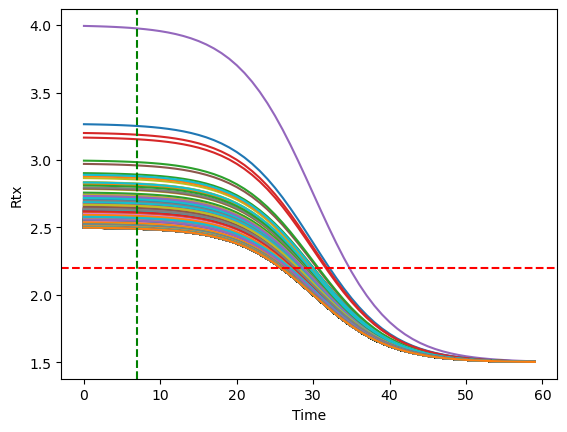

In [ ]:
for i in range(3142):
    plt.plot(Rtx_p[:,i])
plt.xlabel('Time')
plt.ylabel('Rtx')
plt.axhline(2.5, color='red', linestyle='--', label='R=1')
plt.axvline(7.0, color='green', linestyle='--', label='R=0')

In [65]:
np.savetxt('Rtx_p_synthetic.csv', Rtx_p)

change with density

In [6]:
### load the shapefile and land areas

In [8]:
# load pickle module
from scipy.io import loadmat, savemat
import pickle
import geopandas as gpd

In [16]:
fips = loadmat('../data/countyfips_num.mat') ### dictionary
fips_num = fips['countyfips_num'].ravel()
fips_num_int64 = fips_num.astype(np.int64)
# Create DataFrame
df_inf = pd.DataFrame({'FIPS': fips_num_int64, 'pop':pop})
usa = gpd.read_file('../data/cb_2020_us_county_500k/cb_2020_us_county_500k.shp')
# usa_simulation = usa[usa['FIPS'].isin(fips_num_int64)]
usa['FIPS'] = usa['GEOID'].astype('int64')
df_inf_us_geo = gpd.GeoDataFrame(pd.merge(df_inf, usa, how='left', left_on = 'FIPS', right_on='FIPS'))
# inf_us_main = df_inf_us_geo[~df_inf_us_geo['STATEFP'].isin(["02","15","60","66","69","71","72","78"])]

https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2025/TGRSHP2025_TechDoc.pdfhttps://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2025/TGRSHP2025_TechDoc.pdf

see page 3-12 for area calculation

In [52]:
bad_idx = df_inf_us_geo.index[df_inf_us_geo.isna().any(axis=1)]
bad_idx.tolist()
print(df_inf_us_geo.loc[bad_idx,'FIPS'])

92    2261
Name: FIPS, dtype: int64


In [53]:
usa[usa['FIPS'].isin([2063,2066])]
### the 2261 separated into two counties (https://www.cdc.gov/nchs/nvss/bridged_race/county_geography-_changes1990-present.pdf)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,FIPS
312,02,066,02804401,0500000US02066,02066,Copper River,Copper River Census Area,AK,Alaska,05,63952335592,1217429937,"POLYGON ((-147.7443 61.42628, -147.71096 61.42...",2066
2305,02,063,02804400,0500000US02063,02063,Chugach,Chugach Census Area,AK,Alaska,05,24682168359,14538928722,"MULTIPOLYGON (((-144.39455 60.0511, -144.3917 ...",2063


In [55]:
df_inf_us_geo.loc[bad_idx,'ALAND'] = usa.loc[usa['FIPS'].isin([2063,2066]),'ALAND'].sum()
df_inf_us_geo.loc[bad_idx,'AWATER'] = usa.loc[usa['FIPS'].isin([2063,2066]),'AWATER'].sum()
df_inf_us_geo['pop_density'] = df_inf_us_geo['pop'] / (df_inf_us_geo['ALAND']/ 1e6)
#### square meters → square kilometers
density = df_inf_us_geo['pop_density'].values

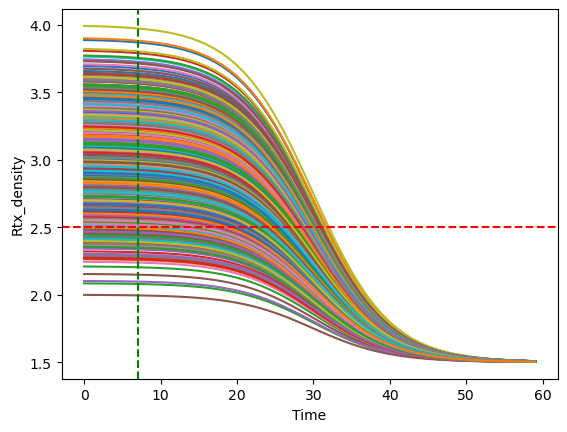

In [78]:
Rtx_d = create_Rtx(np.log(density),min_val=2, max_val=4)
for i in range(3142):
    plt.plot(Rtx_d[:,i])
plt.xlabel('Time')
plt.ylabel('Rtx_density')
plt.axhline(2.5, color='red', linestyle='--', label='R=1')
plt.axvline(7.0, color='green', linestyle='--', label='R=0')

In [74]:
np.savetxt('Rtx_d_log_synthetic.csv', Rtx_d)

In [56]:
def rank_compare(a, b, *, ascending=False, tie_method="average"):
    """
    a, b: 1D arrays of the same length (values for the same items).
    ascending: False -> higher value gets better (smaller) rank (like a leaderboard).
    tie_method: 'average' | 'min' | 'max' | 'dense' | 'first' (pandas rank methods)
    Returns a DataFrame with values, ranks, and rank deltas per index.
    """
    a = pd.Series(a, dtype="float64")
    b = pd.Series(b, dtype="float64")

    # Pairwise valid indices (only rank where both present)
    valid = a.notna() & b.notna()

    # Compute ranks on the valid subset
    a_rank = pd.Series(np.nan, index=a.index, dtype="float64")
    b_rank = pd.Series(np.nan, index=b.index, dtype="float64")

    a_rank.loc[valid] = a.loc[valid].rank(method=tie_method, ascending=ascending)
    b_rank.loc[valid] = b.loc[valid].rank(method=tie_method, ascending=ascending)

    df = pd.DataFrame({
        "value_a": a,
        "rank_a": a_rank,
        "value_b": b,
        "rank_b": b_rank,
    })

    # Rank difference: positive -> moved DOWN the table in b vs a (worse if ascending=False)
    df["delta_rank"] = df["rank_b"] - df["rank_a"]
    df["abs_delta_rank"] = df["delta_rank"].abs()

    # Optional normalized ranks (0..1), useful when you later compare different N
    n = valid.sum()
    if n > 0:
        df["rank_a_norm"] = (df["rank_a"] - 1) / (n - 1) if n > 1 else 0.0
        df["rank_b_norm"] = (df["rank_b"] - 1) / (n - 1) if n > 1 else 0.0
        df["delta_rank_norm"] = df["rank_b_norm"] - df["rank_a_norm"]
    else:
        df["rank_a_norm"] = np.nan
        df["rank_b_norm"] = np.nan
        df["delta_rank_norm"] = np.nan

    return df

In [58]:
compare_df = rank_compare(pop, density, ascending=False, tie_method="average")

In [59]:
compare_df

,value_a,rank_a,value_b,rank_b,delta_rank,abs_delta_rank,rank_a_norm,rank_b_norm,delta_rank_norm
0,55869.0,920.0,36.287191,937.0,17.0,17.0,0.292582,0.297994,0.005412
1,223234.0,307.0,54.213851,707.0,400.0,400.0,0.097421,0.224769,0.127348
2,24686.0,1617.0,10.769754,1994.0,377.0,377.0,0.514486,0.634511,0.120025
3,22394.0,1706.0,13.890433,1774.0,68.0,68.0,0.542821,0.564470,0.021649
4,57826.0,896.0,34.620976,974.0,78.0,78.0,0.284941,0.309774,0.024833
...,...,...,...,...,...,...,...,...,...
3137,42343.0,1130.0,1.567925,2828.0,1698.0,1698.0,0.359440,0.900032,0.540592
3138,23464.0,1660.0,2.266661,2741.0,1081.0,1081.0,0.528176,0.872334,0.344158
3139,20226.0,1810.0,3.751369,2578.0,768.0,768.0,0.575931,0.820439,0.244508
3140,7805.0,2610.0,1.346118,2871.0,261.0,261.0,0.830627,0.913722,0.083095


In [66]:
threshold = 0.05  # 5%

changed = compare_df[ compare_df["delta_rank_norm"].abs() > threshold ]

n_changed = len(changed)
n_total = len(compare_df)

print(f"{n_changed} out of {n_total} items changed more than 5% in normalized rank "
      f"({n_changed/n_total:.1%}).")

1741 out of 3142 items changed more than 5% in normalized rank (55.4%).


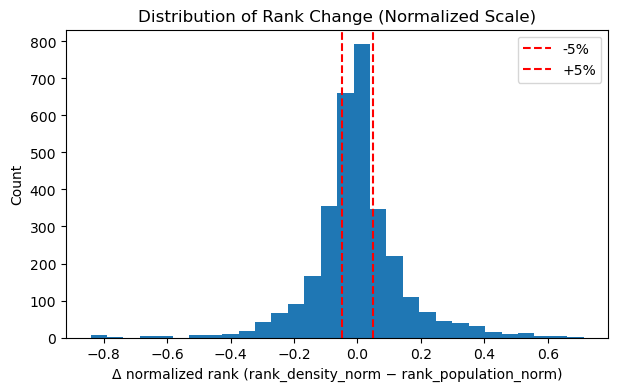

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(compare_df["delta_rank_norm"], bins=30)
plt.axvline(-threshold, color='red', linestyle='--', label='-5%')
plt.axvline(threshold,  color='red', linestyle='--', label='+5%')
plt.xlabel("Δ normalized rank (rank_density_norm − rank_population_norm)")
plt.ylabel("Count")
plt.title("Distribution of Rank Change (Normalized Scale)")
plt.legend()
plt.show()